# Import libraries

In [1]:
import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt

import scipy
from scipy import optimize
from functools import reduce
from numdifftools import Gradient

from typing import Callable, List, Tuple
import itertools
%matplotlib inline


# Generate noisy data

In [2]:
# Generating random numbers
a = np.random.rand()
b = np.random.rand()

x = np.linspace(0, 1., 101, dtype=np.float64)

In [26]:
a, b

(0.368514841627972, 0.6423890816832012)

In [4]:
# Generating random data
def fx(x: NDArray[np.float64], alpha: float, beta: float) -> NDArray[np.float64]:
    theta = np.random.randn(101)
    y = alpha * x + beta
    noisy_y = y  + theta
    return y, noisy_y

In [5]:
y, noisy_y = fx(x, a, b)

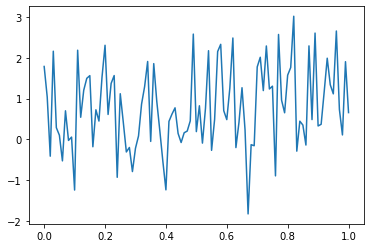

In [6]:
plt.plot(x, noisy_y)

# Define approximating and loss functions 

In [7]:
# linear approximation function
def lin_approx_func(x, a, b):
    return a * x + b

# rational approximation function
def rat_approx_func(x, a, b):        
    return a / (1 + b * x)

In [8]:
# closure of least squares function
def least_squares_linear(y_f, x):
    
    def least_squares_linear_closure(params):
        a, b = params
        return np.sum((lin_approx_func(x, a, b) - y_f) ** 2)
    
    return least_squares_linear_closure

def least_squares_rational(y_f, x):

    def least_squares_rational_closure(params):
        a, b = params
        return np.sum((rat_approx_func(x, a, b) - y_f) ** 2)
    
    return least_squares_rational_closure

In [9]:
least_squares_linear_on_x = least_squares_linear(noisy_y, x)
least_squares_rational_on_x = least_squares_rational(noisy_y, x)

# Different optimization techniques

In [10]:
def gradient_descent(method, a, b, x, y, eps, alpha=1e-3, max_iter=1000):
    path = [(a, b)]

    iter, f_call = 0, 0
    step = 1
    prev_a, prev_b = a, b

    while step >= eps and iter < max_iter:
        iter += 1
        if method == "linear":
            g_a = 2 * np.sum(x * (a * x + b - y))
            g_b = 2 * np.sum(a * x + b - y)
        elif method == "rational":
            grad =  Gradient(least_squares_rational_on_x)([a, b])
            g_a = grad[0]
            g_b = grad[1]
            # g_a = -2 * np.sum((-a  + b * x * y + y) / ((1 + b * x) ** 2))
            # g_b = -2 * np.sum((a * x * (a - y * (b * x + 1))) / ((b * x + 1)**3))

        f_call += 1     

        a -= alpha * g_a
        b -= alpha * g_b
        path.append((a, b))

        #let us use l2 norm of gradient as a condition for stopping
        step = np.sqrt((prev_a - a)**2 + (prev_b - b)**2)
        prev_a, prev_b = a, b
           
    return a, b, iter, f_call, path

In [11]:
def lin_resid(ab, *args):
    a, b = ab
    x, y = args[0], args[1]
    return lin_approx_func(x, a, b) - y

In [12]:
def rat_resid(ab, *args):
    a, b = ab
    x, y = args[0], args[1]
    return rat_approx_func(x, a, b) - y

In [23]:
def precision(ob_a, ob_b):
    return np.sqrt((a - ob_a) ** 2 + (b - ob_b) ** 2)

In [25]:
init_a, init_b = np.random.rand(), np.random.rand()
print('Linear optimization')

a_gd, b_gd, iter, f_call, path = gradient_descent('linear', init_a, init_b , x, noisy_y, .001, .0075)
print(f'Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f} Number of iterations: {:.0f} Precision: {:.4f}'.format(a_gd, b_gd, f_call, iter, precision(a_gd, b_gd)))

cd = optimize.minimize(least_squares_linear_on_x, [init_a, init_b], method='CG', tol=.001, options={'disp': True})
print(f'Conjugate Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f} Precision: {:.4f}'.format(cd.x[0], cd.x[1], precision(cd.x[0], cd.x[1])))

newton = optimize.minimize(least_squares_linear_on_x, [init_a, init_b], method='BFGS', tol=.001, options={'disp': True})
print(f'Newton’s method:\t ','Value a: {:.4f} Value b: {:.4f} Precision: {:.4f}'.format(newton.x[0], newton.x[1], precision(newton.x[0], newton.x[1])))

lm = optimize.least_squares(lin_resid, [init_a, init_b], args=(x, noisy_y), method='lm', xtol=.001)
print(f'Levenberg-Marquardt algorithm:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f} Precision: {:.4f}'.format(lm.x[0], lm.x[1], lm["nfev"], precision(lm.x[0], lm.x[1])))

Linear optimization
Gradient Descent:	  Value a: 0.6782 Value b: 0.4473 Number of f-calculations: 74 Number of iterations: 74 Precision: 0.3660
Optimization terminated successfully.
         Current function value: 96.317752
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Conjugate Gradient Descent:	  Value a: 0.6783 Value b: 0.4477 Precision: 0.3659
Optimization terminated successfully.
         Current function value: 96.317752
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Newton’s method:	  Value a: 0.6783 Value b: 0.4477 Precision: 0.3659
Levenberg-Marquardt algorithm:	  Value a: 0.6783 Value b: 0.4477 Number of f-calculations: 6 Precision: 0.3659


## Visualization of gradient descent

In [14]:
def create_mesh(f):
    x = np.arange(-0.5, 1, 0.01)
    y = np.arange(-0.5, 1, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    mesh_size = range(len(X))

    for i, j in itertools.product(mesh_size, mesh_size):
        x_coor = X[i][j]
        y_coor = Y[i][j]
        Z[i][j] = f(np.array([x_coor, y_coor]))
    return X, Y, Z

In [15]:
def plot_contour(ax, X, Y, Z):
    ax.set(
        title='Path During Gradient descent',
        xlabel='a',
        ylabel='b'
    )
    l_z, r_z  = np.abs(Z).min(), np.abs(Z).max()
    CS = ax.pcolormesh(X, Y, Z,  vmin=l_z, vmax=r_z)
    ax.axis('square')
    return ax, CS

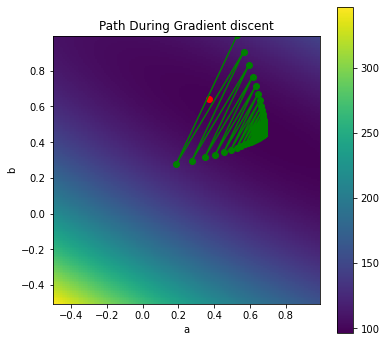

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
X, Y, Z = create_mesh(least_squares_linear_on_x)
ax, CS = plot_contour(ax, X, Y, Z)
fig.colorbar(CS)

ax.plot([a], [b], 'ro')
ax.plot([x[0] for x in path], [x[1] for x in path], 'g-o')
plt.show()

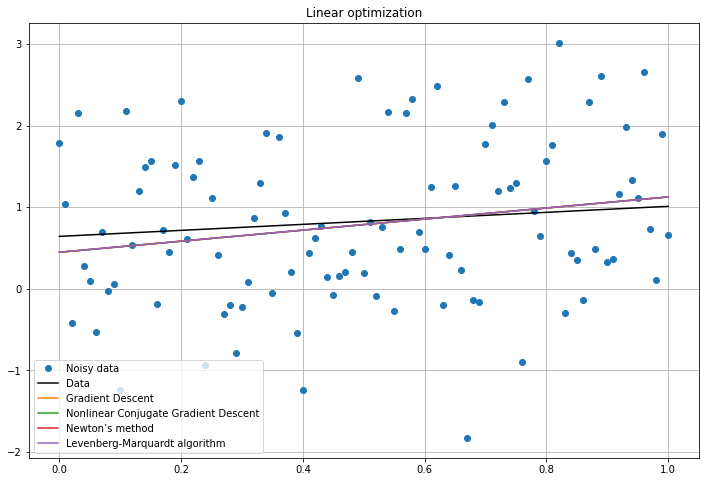

In [17]:
plt.figure(figsize=(12, 8))
plt.title('Linear optimization')
plt.grid()
plt.plot(x, noisy_y, 'o')
plt.plot(x, y, color='black')

plt.plot(x, a_gd * x + b_gd)
plt.plot(x, cd.x[0] * x + cd.x[1])
plt.plot(x, newton.x[0] * x + newton.x[1])
plt.plot(x, lm.x[0] * x + lm.x[1])
    
plt.legend(['Noisy data', 'Data', 'Gradient Descent', 'Nonlinear Conjugate Gradient Descent', 'Newton’s method', 'Levenberg-Marquardt algorithm'])
plt.show()

In [27]:
init_a, init_b = np.random.rand(), np.random.rand()
print('Rational optimization')

a_gd, b_gd, iter, f_call, path = gradient_descent('rational', init_a, init_b , x, noisy_y, .001, .0075)
print(f'Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f} Number of iterations: {:.0f} Precision: {:.4f}'.format(a_gd, b_gd, f_call, iter, precision(a_gd, b_gd)))

cd = optimize.minimize(least_squares_rational_on_x, [init_a, init_b], method='CG', tol=.001, options={'disp': True})
print(f'Conjugate Gradient Descent:\t ','Value a: {:.4f} Value b: {:.4f} Precision: {:.4f}'.format(cd.x[0], cd.x[1], precision(cd.x[0], cd.x[1])))

newton = optimize.minimize(least_squares_rational_on_x, [init_a, init_b], method='BFGS', tol=0.001, options={'disp': True})
print(f'Newton’s method:\t ','Value a: {:.4f} Value b: {:.4f} Precision: {:.4f}'.format(newton.x[0], newton.x[1], precision(newton.x[0], newton.x[1])))

lm = optimize.least_squares(rat_resid, [init_a, init_b], args=(x, noisy_y), method='lm', xtol=0.001)
print(f'Levenberg-Marquardt algorithm:\t ','Value a: {:.4f} Value b: {:.4f} Number of f-calculations: {:.0f} Precision: {:.4f}'.format(lm.x[0], lm.x[1], lm["nfev"], precision(lm.x[0], lm.x[1])))

Rational optimization
Gradient Descent:	  Value a: 0.5104 Value b: -0.6068 Number of f-calculations: 76 Number of iterations: 76 Precision: 1.2572
Optimization terminated successfully.
         Current function value: 95.653567
         Iterations: 10
         Function evaluations: 81
         Gradient evaluations: 27
Conjugate Gradient Descent:	  Value a: 0.5096 Value b: -0.6076 Precision: 1.2580
Optimization terminated successfully.
         Current function value: 95.653567
         Iterations: 8
         Function evaluations: 36
         Gradient evaluations: 12
Newton’s method:	  Value a: 0.5096 Value b: -0.6076 Precision: 1.2580
Levenberg-Marquardt algorithm:	  Value a: 0.5096 Value b: -0.6076 Number of f-calculations: 20 Precision: 1.2580


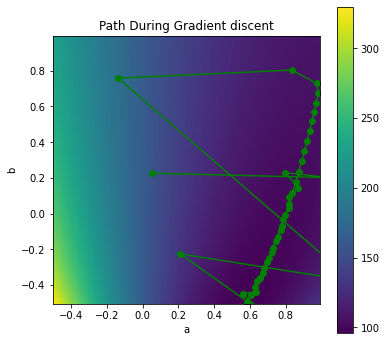

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
X, Y, Z = create_mesh(least_squares_rational_on_x)
ax, CS = plot_contour(ax, X, Y, Z)
fig.colorbar(CS)

ax.plot([x[0] for x in path], [x[1] for x in path], 'g-o')

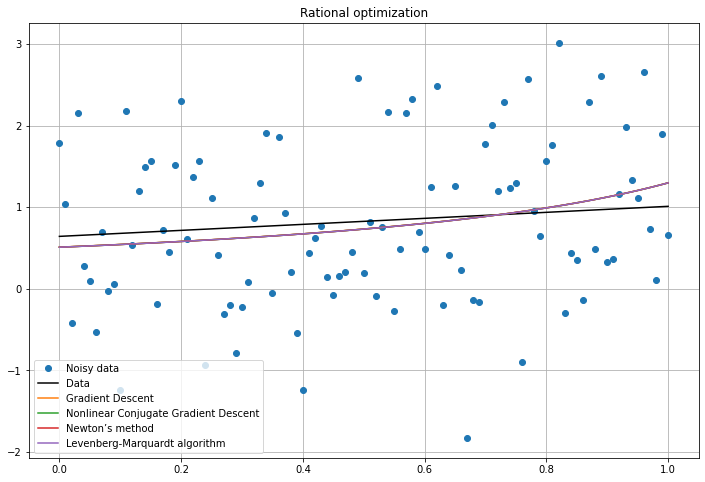

In [20]:
plt.figure(figsize=(12, 8))
plt.title('Rational optimization')
plt.grid()
plt.plot(x, noisy_y, 'o')
plt.plot(x, y, color='black')

plt.plot(x, a_gd / (1 + b_gd * x))
plt.plot(x, cd.x[0] / (1 + cd.x[1] * x))
plt.plot(x, newton.x[0]/ (1 + newton.x[1] * x))
plt.plot(x,  lm.x[0]/ (1 + lm.x[1] * x))
    
plt.legend(['Noisy data', 'Data', 'Gradient Descent', 'Nonlinear Conjugate Gradient Descent', 'Newton’s method', 'Levenberg-Marquardt algorithm'])
plt.show()

In [28]:

print('Linear optimization')
# linear exhaustive search
a_ex, b_ex = optimize.brute(least_squares_linear_on_x, [[0, 1], [0, 1]], disp=True)
print(f'Exhaustive search method:\t', a_ex, b_ex, ' Precision: ', precision(a_ex, b_ex))

# linear optimization Gauss method
gauss = optimize.minimize(least_squares_linear_on_x, [init_a, init_b], method='Powell', tol=.001, options={'disp': True})
print(f'Gauss search method:\t', gauss.x[0], gauss.x[1], ' Precision: ', precision(gauss.x[0], gauss.x[1]))

# linear optimization Nelder-Mead
nelderMead = optimize.minimize(least_squares_linear_on_x, [init_a, init_b], method='Nelder-Mead', tol=.001, options={'disp': True})
print(f'Nelder-Mead method:\t', nelderMead.x[0], nelderMead.x[1], ' Precision: ', precision(nelderMead.x[0], nelderMead.x[1]))

Linear optimization
Optimization terminated successfully.
         Current function value: 96.317752
         Iterations: 23
         Function evaluations: 46
Exhaustive search method:	 0.6783362994341204 0.44771734527978535  Precision:  0.36590493392607876
Optimization terminated successfully.
         Current function value: 96.317752
         Iterations: 3
         Function evaluations: 60
Gauss search method:	 0.6783051679346648 0.4477251867243823  Precision:  0.36587440232099494
Optimization terminated successfully.
         Current function value: 96.317754
         Iterations: 28
         Function evaluations: 51
Nelder-Mead method:	 0.6781143367669364 0.44794114464781787  Precision:  0.3655979316238237


In [30]:
print('Rational optimization')
# rational exhaustive search
a_ex, b_ex = optimize.brute(least_squares_rational_on_x, [[0, 1],[0, 1]], disp=True)
print(f'Exhaustive search method:\t', a_ex, b_ex, ' Precision: ', precision(a_ex, b_ex))

# rational optimization Gauss method
gauss = scipy.optimize.minimize(least_squares_rational_on_x, [init_a, init_b], method='Powell', tol=.001, options={'disp': True})
print(f'Gauss search method:\t', gauss.x[0], gauss.x[1], ' Precision: ', precision(gauss.x[0], gauss.x[1]))

# rational optimization Nelder-Mead
nelderMead = scipy.optimize.minimize(least_squares_rational_on_x, [init_a, init_b], method='Nelder-Mead', tol=.001, options={'disp': True})
print(f'Nelder-Mead method:\t', nelderMead.x[0], nelderMead.x[1], ' Precision: ', precision(nelderMead.x[0], nelderMead.x[1]))

Rational optimization
Optimization terminated successfully.
         Current function value: 95.653567
         Iterations: 54
         Function evaluations: 104
Exhaustive search method:	 0.5095758251003404 -0.6076100064492167  Precision:  1.2579331943271344
Optimization terminated successfully.
         Current function value: 95.653567
         Iterations: 5
         Function evaluations: 125
Gauss search method:	 0.5095113898426584 -0.6077357013120205  Precision:  1.258050873242933
Optimization terminated successfully.
         Current function value: 95.653593
         Iterations: 34
         Function evaluations: 64
Nelder-Mead method:	 0.5099941735188627 -0.6074349533327597  Precision:  1.257806233032684
